## Week 12 Homework (10)

### Q1: define 

- Gaussian Processes (GPs) and stochastic processes generally
- Variational inference using the Evidence Lower Bound (ELBO)


Gaussian Processes (GPs) and stochastic processes generally
- Stochastic Process: A stochastic process is a collection of random variables indexed by time or space. We can be defined as 
$$\left\{X_t\right\}_{t \in T}$$ where $T$ is the index set such as time and each $X_t$ is a random variable. It describes how a system evolves with some element of randomness.

- Gaussian Processes (GPs):A Gaussian Process is a type of stochastic process where any finite subset of random variables has a multivariate normal distribution. A GP is fully defined by: A mean function `m(x)=E[f(x)]`, and a covariance function (kernel) `k(x,x')=Cov(f(x),f(x'))`. We can write as
$$
f(x) \sim \mathcal{G P}\left(m(x), k\left(x, x^{\prime}\right)\right)
$$

-----------------------

Variational inference using the Evidence Lower Bound (ELBO)

- ELBO Derivation: 
We can begin with the marginal likelihood  
$$
\log p(x) = \log \int p(x, z) \, dz
$$

Introduce a variational approximation $q(z)$ and apply Jensen’s inequality:  
$$
\log p(x) = \log \int q(z) \frac{p(x, z)}{q(z)} \, dz \geq \int q(z) \log \frac{p(x, z)}{q(z)} \, dz
$$

This gives us the Evidence Lower Bound (ELBO):  
$$
\text{ELBO}(q) = \mathbb{E}_{q(z)}[\log p(x, z)] - \mathbb{E}_{q(z)}[\log q(z)]
$$

Maximizing the ELBO is equivalent to minimizing the KL divergence between $q(z)$ and the true posterior $p(z \mid x)$.



### Q2: more GPs

Repurpose PyMC documentation to provide a demonstration of Gaussian processes for a different dataset context than the PyMC examples.

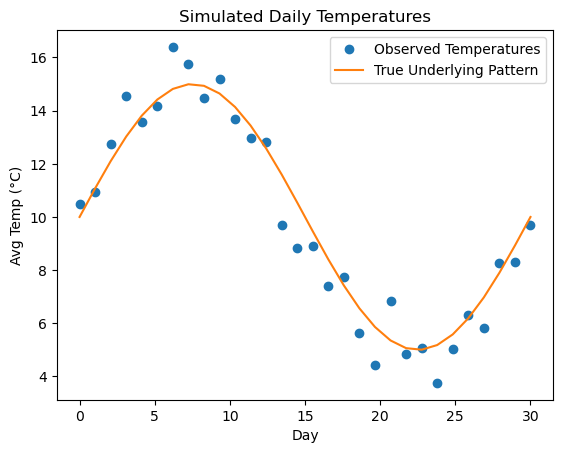

In [1]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt

# Simulated Temperature Data, 30 days of data
np.random.seed(42)
X = np.linspace(0, 30, 30)[:, None]  # day index
true_temp = 10 + 5 * np.sin(X.flatten() * 2 * np.pi / 30)
Y = true_temp + np.random.normal(0, 1, size=X.shape[0])

plt.plot(X, Y, "o", label="Observed Temperatures")
plt.plot(X, true_temp, label="True Underlying Pattern")
plt.xlabel("Day")
plt.ylabel("Avg Temp (°C)")
plt.legend()
plt.title("Simulated Daily Temperatures")
plt.show()

In [2]:
#  PyMC Gaussian Process Model
with pm.Model() as gp_model:
    # Define the covariance function (kernel)
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
    η = pm.HalfNormal("η", sigma=5)
    cov = η**2 * pm.gp.cov.ExpQuad(1, ℓ)

    # GP prior
    gp = pm.gp.Marginal(cov_func=cov)
    
    σ = pm.HalfNormal("σ", sigma=1)
    y_ = gp.marginal_likelihood("y", X=X, y=Y, noise=σ)

    trace = pm.sample(1000, chains=2, tune=1000, target_accept=0.9)


/opt/conda/lib/python3.11/site-packages/pymc/gp/gp.py:56: FutureWarning: The 'noise' parameter has been been changed to 'sigma' in order to standardize the GP API and will be deprecated in future releases.
  warnings.warn(_noise_deprecation_warning, FutureWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [ℓ, η, σ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 41 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


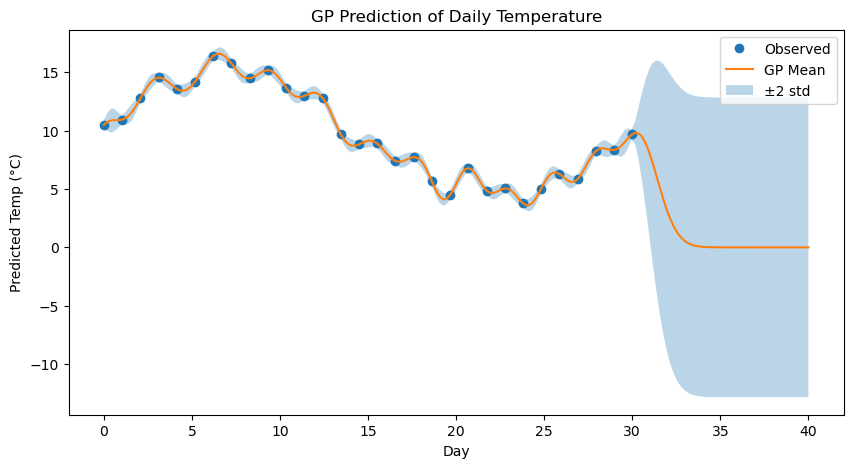

In [3]:
# Posterior predictive
X_new = np.linspace(0, 40, 200)[:, None]

with pm.Model() as gp_model:
    mu, var = gp.predict(X_new, point=pm.summary(trace).mean().to_dict(), diag=True)
    sd = np.sqrt(var)

plt.figure(figsize=(10, 5))
plt.plot(X, Y, "o", label="Observed")
plt.plot(X_new, mu, label="GP Mean")
plt.fill_between(X_new.flatten(), mu - 2*sd, mu + 2*sd, alpha=0.3, label="±2 std")
plt.xlabel("Day")
plt.ylabel("Predicted Temp (°C)")
plt.title("GP Prediction of Daily Temperature")
plt.legend()
plt.show()


### Q3: more VI/ELBO

Repurpose PyMC documentation to provide a demonstration of a neural network fit with variational inference for a different dataset context than the PyMC examples.



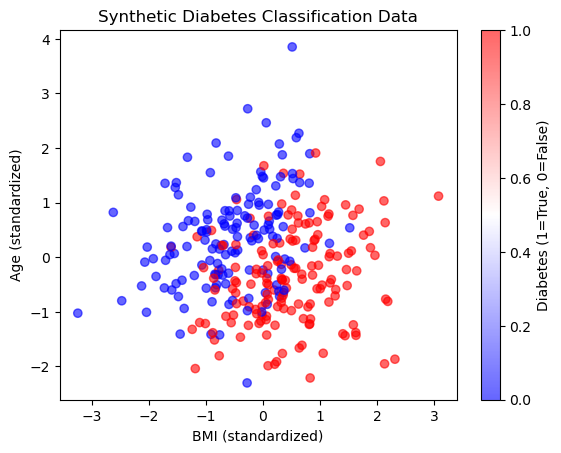

In [4]:
import pymc as pm
import numpy as np
import pytensor.tensor as pt
import matplotlib.pyplot as plt

# Simulate data: BMI and Age -> Diabetes (binary classification)
np.random.seed(42)
n_samples = 300
X = np.random.normal(0, 1, size=(n_samples, 2))  # features: BMI and age (standardized)
true_w = np.array([2.0, -1.5]) # weights: BMI has strong positive effect
logits = X @ true_w + 0.2   # add small intercept
p = 1 / (1 + np.exp(-logits))
y = np.random.binomial(n=1, p=p)

# Plot data
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="bwr", alpha=0.6)
plt.xlabel("BMI (standardized)")
plt.ylabel("Age (standardized)")
plt.title("Synthetic Diabetes Classification Data")
plt.colorbar(label="Diabetes (1=True, 0=False)")
plt.show()



In [5]:
# Build Bayesian Neural Network using PyMC and fit with ADVI
with pm.Model() as vi_model:
    # Layer 1: weights and bias
    w1 = pm.Normal("w1", mu=0, sigma=1, shape=(2, 5))
    b1 = pm.Normal("b1", mu=0, sigma=1, shape=(5,))
    
    # Output layer
    w2 = pm.Normal("w2", mu=0, sigma=1, shape=(5,))
    b2 = pm.Normal("b2", mu=0, sigma=1)
    
    # Neural net forward pass
    hidden = pm.math.tanh(pt.dot(X, w1) + b1)
    out = pm.math.dot(hidden, w2) + b2
    
    # Likelihood: logistic output for binary classification
    y_obs = pm.Bernoulli("y_obs", logit_p=out, observed=y)
    
    # Fit with Variational Inference (ADVI)
    approx = pm.fit(10000, method="advi", obj_optimizer=pm.adagrad(learning_rate=0.01))
    trace_ = approx.sample(1000)

Finished [100%]: Average Loss = 230.66
